In [1]:
# Cell 1 – Imports and Configuration
import os
import numpy as np
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import find_peaks, butter, filtfilt

# Display plots inline
%matplotlib inline

# Path to your WFDB recordings folder
DATA_DIR = "source1"
RECORD_NAME = "100001"  # change as needed
RECORD_PATH = os.path.join(DATA_DIR, RECORD_NAME, f"{RECORD_NAME}_ECG")
ANN_PATH    = os.path.join(DATA_DIR, RECORD_NAME, f"{RECORD_NAME}_ANN.csv")


In [2]:
# Cell 2 – Helper Functions

def center(signal):
    """Subtract mean to zero-center."""
    return signal - np.mean(signal)

def highpass(signal, fs, cutoff=0.5, order=1):
    """Simple Butterworth high-pass filter."""
    b, a = butter(order, cutoff/(0.5*fs), btype='high')
    return filtfilt(b, a, signal)

def remove_baseline_fft(signal, fs, lowcut=0.5):
    """Zero out very low frequencies via FFT."""
    sp = fft(signal)
    freqs = np.fft.fftfreq(len(signal), 1/fs)
    mask = np.abs(freqs) < lowcut
    sp[mask] = 0
    return np.real(ifft(sp))

def detect_rpeaks(signal, height=None, distance=None):
    """Wrapper around scipy.find_peaks for R‑peaks."""
    # dynamic threshold if not provided
    if height is None:
        height = np.percentile(signal, 95)
    peaks, _ = find_peaks(signal, height=height, distance=distance)
    return peaks

def compute_bpm(peaks, fs, window_sec=15):
    """Compute BPM in consecutive windows."""
    duration = peaks[-1] / fs
    nwin = int(duration // window_sec)
    bpms = []
    for w in range(nwin):
        start, end = w*window_sec*fs, (w+1)*window_sec*fs
        count = np.sum((peaks >= start) & (peaks < end))
        bpms.append(count * 60 / window_sec)
    return np.array(bpms)


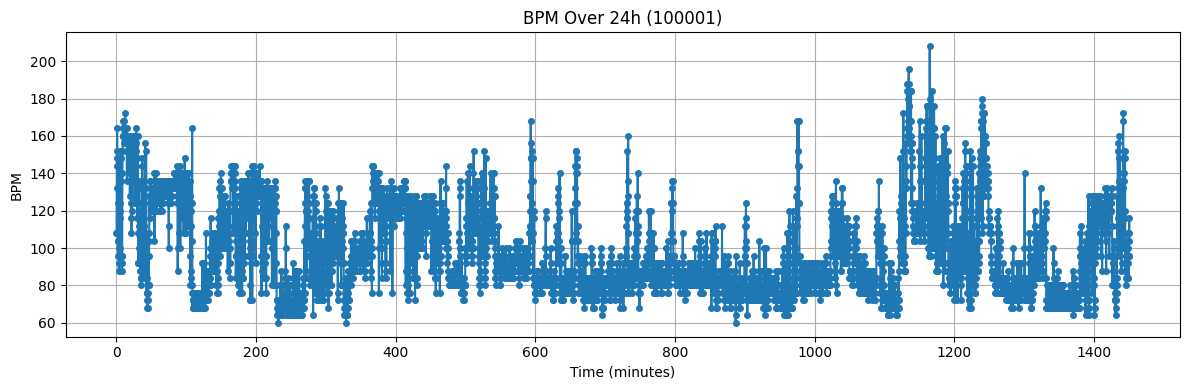

Sampling rate: 1000 Hz
Total samples: 87,087,000
Detected R‑peaks: 142,647
Average BPM: 98.3


In [3]:
# Cell 3 – Main 24‑Hour ECG Processing

# 1) Load and preprocess
rec   = wfdb.rdrecord(RECORD_PATH)
fs    = rec.fs
ecg   = rec.p_signal[:,0]
ecg   = center(ecg)
ecg   = highpass(ecg, fs, cutoff=0.5)

# 2) (Optional) FFT baseline removal
ecg = remove_baseline_fft(ecg, fs, lowcut=0.5)

# 3) R‑peak detection
rpeaks = detect_rpeaks(ecg, distance=int(0.2*fs))  # min 200 ms apart

# 4) BPM over time
bpms = compute_bpm(rpeaks, fs, window_sec=15)
times = np.arange(len(bpms)) * (15/60)  # in minutes

# 5) Plot results
plt.figure(figsize=(12,4))
plt.plot(times, bpms, '-o', markersize=4)
plt.title(f"BPM Over 24h ({RECORD_NAME})")
plt.xlabel("Time (minutes)")
plt.ylabel("BPM")
plt.grid(True)
plt.tight_layout()
plt.show()

# 6) Print summary
print(f"Sampling rate: {fs} Hz")
print(f"Total samples: {len(ecg):,}")
print(f"Detected R‑peaks: {len(rpeaks):,}")
print(f"Average BPM: {np.mean(bpms):.1f}")


In [4]:
def evaluate_detection(true_peaks, detected_peaks, correct_threshold=1e-4):
    correct = 0
    total   = len(true_peaks)
    for t in true_peaks:
        for d in detected_peaks:
            if abs((t+1)/(d+1) - 1) < correct_threshold:
                correct += 1
                break
    return correct, total - correct, total, len(detected_peaks)

def test_file(path, sampfrom=0, nsamp=100000, thresh=1e-4):
    sig, _     = wfdb.rdsamp(path, sampfrom=sampfrom, sampto=sampfrom+nsamp)
    true_peaks = wfdb.rdann(path, 'atr', sampfrom=sampfrom, sampto=sampfrom+nsamp).sample
    det_peaks  = find_peaks(sig[:,0], height=np.percentile(sig[:,0],95), distance=200)[0]
    return evaluate_detection(true_peaks, det_peaks, thresh)

rows = []
succ, tot = 0, 0
for f in os.listdir("source2"):
    if not f.endswith(".dat"): continue
    base = f[:-4]
    c, w, t, p = test_file(f"source2/{base}")
    succ += c; tot += t
    rows.append([base, c, w, t, 100*c/t])
df = pd.DataFrame(rows, columns=["File","Correct","Wrong","Total","Accuracy (%)"])
print(df)
print(f"Overall accuracy: {succ/tot*100:.2f}%")

     File  Correct  Wrong  Total  Accuracy (%)
0   17052      248    870   1118     22.182469
1   16795      258    801   1059     24.362606
2   16539      300    795   1095     27.397260
3   18177      299   1194   1493     20.026792
4   16773      268   1123   1391     19.266715
5   16265      301   1016   1317     22.854973
6   16273      270    973   1243     21.721641
7   16272      300    697    997     30.090271
8   19093      320    641    961     33.298647
9   16786      294    670    964     30.497925
10  17453      310    724   1034     29.980658
11  19090      330    818   1148     28.745645
12  16420      260    894   1154     22.530329
13  19830      337   1087   1424     23.665730
14  19140      276    987   1263     21.852732
15  19088      267   1114   1381     19.333816
16  18184      265    936   1201     22.064946
17  16483      255    916   1171     21.776260
Overall accuracy: 24.09%


Detected 3717 anomalies, matched 47/47 = 100.0%


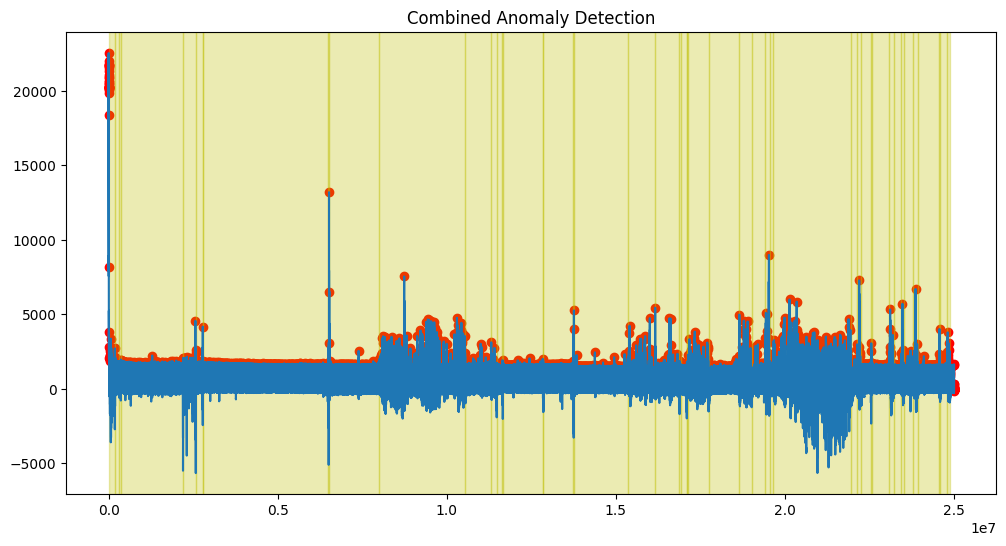

In [5]:
def detect_fft(sig, thr=1000.0):
    S = np.fft.fft(sig); M = np.abs(S)
    m = M.mean()
    return np.where(M > thr*m)[0]

def detect_rolling(sig, win=1000, thr=15.5):
    m = np.convolve(sig, np.ones(win)/win, mode='same')
    s = np.sqrt(np.convolve((sig-m)**2, np.ones(win)/win, mode='same'))
    return np.where(abs(sig-m) > thr*s)[0]

def detect_iqr(sig, k=150.5):
    q1,q3 = np.percentile(sig,[25,75])
    iqr   = q3-q1
    lb, ub= q1-k*iqr, q3+k*iqr
    return np.where((sig<lb)|(sig>ub))[0]

def detect_peaks(sig, h=15.5, d=5000):
    p,_ = find_peaks(sig, height=h, distance=d)
    return p

def process_signal(path_sig, path_ann, fs=1000, dur=25000):
    rec = wfdb.rdrecord(path_sig)
    sig = rec.p_signal[:min(len(rec.p_signal),fs*dur),0]
    a1 = detect_fft(sig)
    a2 = detect_rolling(sig)
    a3 = detect_iqr(sig)
    a4 = detect_peaks(sig)
    ann = pd.read_csv(path_ann, header=None).iloc[:,:2].values
    ann = ann[ann[:,1] < len(sig)]
    comb = np.unique(np.concatenate([a1,a2,a3,a4]))
    match = sum(any(s<=x<e for x in comb) for s,e in ann)
    print(f"Detected {len(comb)} anomalies, matched {match}/{len(ann)} = {match/len(ann)*100:.1f}%")
    plt.figure(figsize=(12,6))
    plt.plot(sig); plt.scatter(comb, sig[comb], c='r')
    for s,e in ann: plt.axvspan(s,e,color='y',alpha=0.3)
    plt.title("Combined Anomaly Detection"); plt.show()

process_signal("source1/100001/100001_ECG","source1/100001/100001_ANN.csv")

,Statistika,Value
0,Matched,21.000000
1,Accuracy (%),77.777778


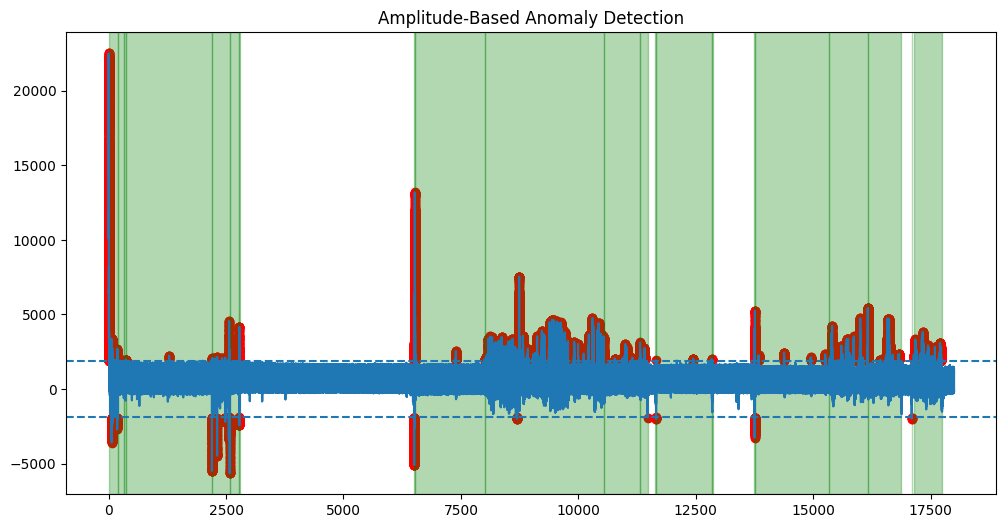

In [6]:
def detect_amplitude(sig, k=3.7):
    m, s = sig.mean(), sig.std()
    th   = m + k*s
    return np.where(abs(sig)>th)[0], th

def process_amp(path_sig, path_ann, fs=1000, dur=18000):
    rec   = wfdb.rdrecord(path_sig)
    sig   = rec.p_signal[:min(len(rec.p_signal),fs*dur),0]
    sig  -= sig.mean()
    idx, th = detect_amplitude(sig)
    ann   = pd.read_csv(path_ann, header=None).iloc[:,:2]
    ann   = ann[ann[1]<len(sig)]
    match = sum(any(s<=i<e for i in idx) for s,e in ann.values)
    stats = pd.DataFrame({
        "Statistika":["Matched", "Accuracy (%)"],
        "Value":    [match, match/len(ann)*100]
    })
    display(stats)
    t = np.arange(len(sig))/fs
    plt.figure(figsize=(12,6))
    plt.plot(t, sig); plt.scatter(t[idx], sig[idx], c='r')
    plt.axhline(th, linestyle='--'); plt.axhline(-th, linestyle='--')
    for s,e in ann.values:
        if any(s<=i<e for i in idx): plt.axvspan(s/fs,e/fs,color='g',alpha=0.3)
    plt.title("Amplitude‑Based Anomaly Detection"); plt.show()

process_amp("source1/100001/100001_ECG","source1/100001/100001_ANN.csv")

In [7]:
# 1) R‑peak detection evaluation on testdata/
def evaluate_detection(true_peaks, det_peaks, tol=1e-4):
    correct = sum(
        any(abs((t+1)/(d+1) - 1) < tol for d in det_peaks)
        for t in true_peaks
    )
    return correct, len(true_peaks), len(det_peaks)

def test_rpeak_folder(test_folder="testdata"):
    rows = []
    tot_corr, tot_true = 0, 0
    for f in os.listdir(test_folder):
        if not f.endswith(".dat"): continue
        base = f[:-4]
        path = os.path.join(test_folder, base)
        sig, _      = wfdb.rdsamp(path)
        true_peaks  = wfdb.rdann(path, 'atr').sample
        det_peaks   = find_peaks(sig[:,0], height=np.percentile(sig[:,0],95), distance=200)[0]
        corr, true, det = evaluate_detection(true_peaks, det_peaks)
        rows.append([base, corr, true-corr, true, det, 100*corr/true])
        tot_corr += corr; tot_true += true
    df1 = pd.DataFrame(rows, columns=["File","Correct","Missed","Total True","Detected","Accuracy (%)"])
    print("R‑peak Detection Results:")
    print(df1)
    print(f"Overall Accuracy: {tot_corr/tot_true*100:.2f}%\n")

# 2) Amplitude‑based anomaly detection evaluation across all data/ subjects
def detect_amplitude(sig, k=3.7):
    m, s = sig.mean(), sig.std()
    th = m + k*s
    return np.where(np.abs(sig) > th)[0]

def batch_anomaly_evaluation(data_dir="data", duration=18000):
    rows = []
    for rec in sorted(os.listdir(data_dir)):
        sig_fp = os.path.join(data_dir, rec, f"{rec}_ECG")
        ann_fp = os.path.join(data_dir, rec, f"{rec}_ANN.csv")
        if not (os.path.exists(sig_fp) and os.path.exists(ann_fp)):
            continue
        rec_obj = wfdb.rdrecord(sig_fp)
        sig = rec_obj.p_signal[:,0]
        sig = sig[:min(len(sig), rec_obj.fs*duration)]
        sig -= sig.mean()
        anomalies = detect_amplitude(sig)
        ann = pd.read_csv(ann_fp, header=None).iloc[:,:2].values
        ann = ann[ann[:,1] < len(sig)]
        matched = sum(any(s<=a<e for a in anomalies) for s,e in ann)
        total   = len(ann)
        acc     = 100*matched/total if total>0 else 0
        rows.append([rec, matched, total, acc])
    df2 = pd.DataFrame(rows, columns=["Record","Matched","Total Annot.","Accuracy (%)"])
    print("Amplitude Anomaly Detection Results:")
    print(df2)

# Run both evaluations
test_rpeak_folder("source2")
batch_anomaly_evaluation("source1")

KeyboardInterrupt: 